In [1]:
import numpy as np
import cv2 as cv
from zipfile import ZipFile
import os
import string
import pandas as pd
import operator
from IPython.display import Image

In [2]:
# Adicionar o arquivo ORL.Zip ao Colab (upload)
zipName = "ORL.zip" # Especifica o nome do arquivo para ser descompactado

# Descompacta o arquivo no diretório do Colab (facilitar importação das imagens) 
with ZipFile(zipName, 'r') as zip:
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

Extracting all the files now...
Done!


In [3]:
fileList = os.listdir('ORL2/')
print (len(fileList))

410


In [4]:
person = []
for fileName in fileList:
  # inserindo as id e labels para cada pessoa
  strName = str(fileName)
  strName = strName.replace('.jpg', '')
  id, label = strName.split('_', 1)

  # convertendo todas as imagens em escala de cinza
  image = cv.imread(os.path.join('ORL2/',fileName), cv.IMREAD_GRAYSCALE)
  
  # redimensionando as imagens para o padrão
  height = 80
  width = 80
  dsize = (height, width)
  image = cv.resize(image, dsize)
  
  # aplica transposição da imagem
  image = np.transpose(image) 
  
  # reshape das imagens (transformacao em vetor)
  image = image.reshape(1, height*width)
  
  # atribuindo a imagem a pessoa e aplicando float64
  data = np.float64(image)

  person.append([int(id), int(label), data])

# atribuindo lista de dados em formato de dataframe
df = pd.DataFrame(person, columns=['id', 'label', 'data'])

In [5]:
# ordenando df por id e label
df = df.sort_values(by=['id', 'label'], ascending=True)

In [6]:
# dividindo o dataframe para treino e teste 

p = 0.7 # porcentagem de amostras para treino (0 < p < 1) - teste = 1-p

# criando grupo de treino randomizado
trainData = df.sample(frac=p)

# criando grupo de testes removendo o grupo de treino do df
testData = df.drop(trainData.index)

In [7]:
print ('O tamanho das amostras de treino é:', len(trainData))
print ('O tamanho das amostras de teste é:', len(testData))

O tamanho das amostras de treino é: 287
O tamanho das amostras de teste é: 123


In [8]:
# geração da imagem média
meanImage = np.mean(trainData['data'])
print (meanImage)

[[63.12891986 77.25087108 72.80836237 ... 63.16027875 66.96864111
  56.15679443]]


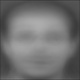

In [9]:
# salvar imagem média para verificação

# convertendo o vetor de imagem média para matriz (psi)
saveMeanImg = np.reshape(meanImage, (width, height))

# aplicando a transposição das linhas para coluna (imagem de lado)
saveMeanImg = np.transpose(saveMeanImg)

# salvando arquivo de imagem media para verificação
cv.imwrite('meanImg.jpg', saveMeanImg)
Image('meanImg.jpg')

In [10]:
# criando a matriz de diferenciais e subtraindo da media

# coletando os dados do df de treino
dataCol = trainData['data'].to_numpy()
labelListTrain = trainData['label'].to_numpy() # label das imagens de treino (nome da pessoa)

# convertendo os dados coletados para matriz 287x6400
dataMat = np.concatenate(dataCol, axis=0)

# calculando a matriz de diferenças (fi)
diffImage = dataMat - meanImage

# calculando a transposta de diff, assim cada pessoa fica em uma coluna (alfa)
diffImage = np.transpose(diffImage)
print ('Shape da diffImage:', diffImage.shape)

Shape da diffImage: (6400, 287)


In [11]:
# calculo da matriz de covariancia

# convertendo os dados para matriz
matA = np.transpose(dataMat)
print ('Shape da matA:', matA.shape)

# criando matB que é a transposta de matA
matB = np.transpose(matA)
print ('Shape da matB:', matB.shape)

# calculando a matriz de covariancia (6400x6400)
matCovar = np.matmul(matA, matB) # Matriz L
print ('Shape da matCovar:', matCovar.shape)

Shape da matA: (6400, 287)
Shape da matB: (287, 6400)
Shape da matCovar: (6400, 6400)


In [12]:
# cálculo dos autovalores e autovetores
w, v = np.linalg.eig(matCovar)

# encontrar os índices decrescentes (maiores autovalores)
idx = w.argsort()[::-1]

# ordena os autovalores e auto vetores em ordem decrescente
w = w[idx]
v = v[:,idx]
print ('Eigenvalues :', len(w))
print ('Eigenvectors:', len(v))

Eigenvalues : 6400
Eigenvectors: 6400


In [19]:
lstEigenvectors = []

# inicia o for com range de k componentes principais (calcula toda sequencia dentro desse for)
for k in range (10,21,1):
  idxComp = list(range(0,k,1))
  matEigenvectors = v[:,idxComp]
  #print ('Shape matEigenvectors:', matEigenvectors.shape)

  # calculo das eigenfaces U
  matEigenface = np.matmul(matCovar, matEigenvectors)
  #print ('Shape matEigenface:', matEigenface.shape)

  # cálculo das projeções
  # para cada k (consequentemente eigenface)
  # matProjectionsTrain (omega) = eigenFaces.transposta * diffImage (alfa)

  # calculando a transposta da matriz de eigenfaces
  matEigenface_t = np.transpose(matEigenface)
  #print ('Shape matEigenface_t:', matEigenface_t.shape)
  matProjectionsTrain = np.matmul(matEigenface_t, diffImage)
  #print ('Shape matProjectionsTrain:', matProjectionsTrain.shape)

  # etapa de teste

  # coletando os dados do df de treino
  dataColTest = testData['data'].to_numpy()
  labelListTest = testData['label'].to_numpy() # label das imagens de teste (nome da pessoa)

  # convertendo os dados coletados para matriz 
  dataMatTest = np.concatenate(dataColTest, axis=0)

  # calculando a matriz de diferenças (fi)
  diffImageTest = dataMatTest - meanImage

  # calculando a transposta de diff, assim cada pessoa fica em uma coluna (alfa)
  diffImageTest = np.transpose(diffImageTest)
  #print ('Shape da diffImage:', diffImageTest.shape)

  # projetando as imagens desconhecidas no espaço de treino
  matProjectionsTest = np.matmul(matEigenface_t, diffImageTest) 
  #print ('Shape matProjectionsTest:', matProjectionsTest.shape)
  
  # salvando todas imagens desconhecidas em uma matriz (cada coluna é uma pessoa desconhecida)

  totalTestImages = len(testData['data'])
  imageRecognized = 0
  counter = 0
  for i in range(len(testData['data'])):
    distList = []
    distList.clear()
    labelActual = labelListTest[i]
    for j in range(len(trainData['data'])):
      vecA = matProjectionsTest[:,i]
      vecB = matProjectionsTrain[:,j]
      dist = np.linalg.norm(vecA-vecB)
      distList.append(abs(dist))
      counter += 1
    indexMin = distList.index(min(distList))
    labelEstimation = labelListTrain[indexMin]
    if labelEstimation == labelActual:
      imageRecognized += 1
      #print ('Imagem reconhecida! Total = {} de {}'.format(imageRecognized, totalTestImages))
    else:
      #print ('Pessoa estimada: {} | Pessoa real: {}'.format(labelEstimation, labelActual))
      continue

  accuracy = (imageRecognized/totalTestImages)*100
  print('{} componentes principais, acurácia: {:.1f}%'.format(k, accuracy))
  #print ('Total de verificações:', counter)

10 componentes principais, acurácia: 29.3%
11 componentes principais, acurácia: 29.3%
12 componentes principais, acurácia: 29.3%
13 componentes principais, acurácia: 29.3%
14 componentes principais, acurácia: 29.3%
15 componentes principais, acurácia: 29.3%
16 componentes principais, acurácia: 29.3%
17 componentes principais, acurácia: 29.3%
18 componentes principais, acurácia: 29.3%
19 componentes principais, acurácia: 29.3%
20 componentes principais, acurácia: 29.3%


Nos testes realizados, a acurácia apresentada pelo modelo anterior ficou muito baixa. Por isso, buscou-se uma alternativa de melhoria com o uso do OpenCV para cálculos dos EigenVectors, apresentado abaixo.

In [21]:
# EigenVectors calculados com OpenCV

# matEigenface = matCovar * matEigenvectors (para k componentes principais)
lstEigenvectors = []

# inicia o for com range de k componentes principais (calcula toda sequencia dentro desse for)
for k in range (10,21,1):
  
  # matriz de entrada deve deve ter o conteudo em linhas (l=pessoa x c=dados imagens)
  mean, matEigenvectors = cv.PCACompute(matB, mean=None, maxComponents=k)
  matEigenvectors = np.transpose(matEigenvectors)
  #print ('Shape matEigenvectors:', matEigenvectors.shape)

  # calculo das eigenfaces U
  matEigenface = np.matmul(matCovar, matEigenvectors)
  #print ('Shape matEigenface:', matEigenface.shape)

  # cálculo das projeções
  # para cada k (consequentemente eigenface)
  # matProjectionsTrain (omega) = eigenFaces.transposta * diffImage (alfa)

  # calculando a transposta da matriz de eigenfaces
  matEigenface_t = np.transpose(matEigenface)
  #print ('Shape matEigenface_t:', matEigenface_t.shape)

  matProjectionsTrain = np.matmul(matEigenface_t, diffImage)
  #print ('Shape matProjectionsTrain:', matProjectionsTrain.shape)

  # coletando os dados do df de treino
  dataColTest = testData['data'].to_numpy()
  labelListTest = testData['label'].to_numpy() # label das imagens de teste (nome da pessoa)

  # convertendo os dados coletados para matriz 
  dataMatTest = np.concatenate(dataColTest, axis=0)

  # calculando a matriz de diferenças (fi)
  diffImageTest = dataMatTest - meanImage

  # calculando a transposta de diff, assim cada pessoa fica em uma coluna (alfa)
  diffImageTest = np.transpose(diffImageTest)
  #print ('Shape da diffImage:', diffImageTest.shape)

  # projetando as imagens desconhecidas no espaço de treino
  matProjectionsTest = np.matmul(matEigenface_t, diffImageTest) # fazer para cada um (0 até len(testData))
  #print ('Shape matProjectionsTest:', matProjectionsTest.shape)
  # salvando todas imagens desconhecidas em uma matriz (cada coluna é uma pessoa desconhecida)

  totalTestImages = len(testData['data'])
  imageRecognized = 0
  for i in range(len(testData['data'])):
    distList = []
    distList.clear()
    for j in range(len(trainData['data'])):
      vecA = matProjectionsTest[:,i]
      vecB = matProjectionsTrain[:,j]
      dist = np.sqrt((vecA-vecB)**2)
      norm = np.linalg.norm(dist)
      distList.append(norm)
      #print(distList)
    indexMin = distList.index(min(distList))
    labelEstimation = labelListTrain[indexMin]
    labelActual = labelListTest[i]
    #print (labelEstimation, labelActual)
    if labelEstimation == labelActual:
      imageRecognized += 1
      #print ('Imagem reconhecida! Total = {} de {}'.format(imageRecognized, totalTestImages))

  accuracy = (imageRecognized/totalTestImages)*100
  print('{} componentes principais, acurácia: {:.1f}%'.format(k, accuracy))




10 componentes principais, acurácia: 30.9%
11 componentes principais, acurácia: 30.9%
12 componentes principais, acurácia: 31.7%
13 componentes principais, acurácia: 31.7%
14 componentes principais, acurácia: 31.7%
15 componentes principais, acurácia: 31.7%
16 componentes principais, acurácia: 31.7%
17 componentes principais, acurácia: 31.7%
18 componentes principais, acurácia: 31.7%
19 componentes principais, acurácia: 31.7%
20 componentes principais, acurácia: 31.7%


É possível verificar uma leve melhora na acurácia com o uso de 12 ou mais componentes principais. Contudo, esse resultado ficou muito abaixo do apresentado pelo algoritmo desenvolvido em sala (Java). Isso pode ter ocorrido por baixa eficiência nas ferramentas empregadas nesse código ou eventualmente um erro na escrita do algoritmo, não detectado até o momento. 